In [119]:
import os
import json
import numpy as np

tasks = ["mmlu", "tydiqa", "bbh"]
ckpts = [105, 211, 317, 420]
model_name="llama-2-7b-hf"
results_dir = f'/scratch/gpfs/mengzhou/space10/final/loss/{model_name}'
pretrain_loss_file = os.path.join(results_dir, "{}", model_name)
random_selection_loss_file = os.path.join(results_dir, "{}", "p0.05_seed{}_lora_ckpt{}_random")
less_selection_loss_file = os.path.join(results_dir, "{}", "p0.05_seed{}_lora_ckpt{}_less")

In [110]:
def get_loss(loss_file):
    if not loss_file.endswith("txt"):
        loss_file = os.path.join(loss_file, "loss.txt")
    with open(loss_file, 'r') as f:
        return json.load(f)["loss"]

In [111]:
pretrain_losses = {}
for task in tasks:
    pretrain_loss = get_loss(pretrain_loss_file.format(task))
    pretrain_losses[task] = pretrain_loss
    

In [112]:
random_selection_losses = {}
for task in tasks:
    random_selection_losses[task] = {}
    for ckpt in ckpts:
        random_selection_losses[task][ckpt] = {}
        losses = []
        for seed in [3, 6, 9]: 
            loss = get_loss(random_selection_loss_file.format(task, seed, ckpt))
            losses.append(loss)
        random_selection_losses[task][ckpt]["loss"] = np.mean(losses)
        random_selection_losses[task][ckpt]["std"] = np.std(losses)



In [113]:
less_selection_losses = {}
for task in tasks:
    less_selection_losses[task] = {}
    for ckpt in ckpts:
        less_selection_losses[task][ckpt] = {}
        losses = []
        for seed in [3, 6, 9]:
            loss = get_loss(less_selection_loss_file.format(task, seed, ckpt))
            losses.append(loss)
        less_selection_losses[task][ckpt]["loss"] = np.mean(losses)
        less_selection_losses[task][ckpt]["std"] = np.std(losses)



In [114]:
for task in random_selection_losses:
    random_selection_losses[task][0] = {"loss": pretrain_losses[task], "std": 0}
    less_selection_losses[task][0] = {"loss": pretrain_losses[task], "std": 0}

In [120]:
import pandas as pd
df = pd.read_csv(f"/scratch/gpfs/mengzhou/space10/final/loss/{model_name}/loss_acc.csv")
dfs = [df[df["method"] == "Random"], df[df["method"] == "Less"]]

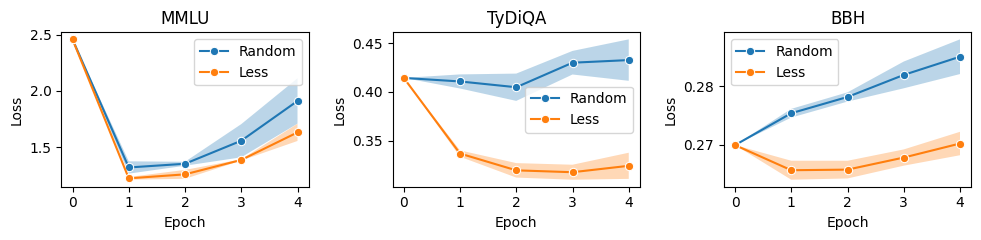

In [122]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create a plot for each task
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 2.5))
labels = ['Random', 'Less']


for i, data in enumerate([random_selection_losses, less_selection_losses]):
    df = dfs[i]
    # Loop through each task and plot
    for j, (ax, task) in enumerate(zip(axes, data.keys())):
        task_data = df[df['task'] == task]
        sns.lineplot(x='epoch', y='loss', data=task_data, ax=ax, marker='o', label=labels[i])
        lower_bound = task_data["loss"] - task_data["std"] 
        upper_bound = task_data["loss"] + task_data["std"]
        x_axis = task_data["epoch"]
        ax.fill_between(x_axis.values, lower_bound.values, upper_bound.values, alpha=.3)

        # Set title and labels
        ax.set_title(task_names[j])
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')


# Adjust layout to prevent overlap
plt.tight_layout()
# plt.show()
plt.savefig(f"{model_name}_loss.pdf", bbox_inches='tight')

In [104]:
random_accuracy_data = [
    [55.8, 57.3, 55.0, 54.7, 54.5],
    [53.1, 25.8, 26.9, 27.1, 36.0],
    [22.2, 37.9, 39.5, 42.0, 40.3]
]

random_accuracy_std = [
    [0.0, 1.3, 0.7, 0.9, 0.7],
    [0.0, 8.4, 3.5, 3.4, 3.0],
    [0.0, 4.0, 5.4, 5.2, 2.6]
]
    
less_accuracy_data = [
    [55.8, 55.8, 54.9, 54.6, 55.2],
    [53.1, 31.8, 33.6, 32.1, 31.5],
    [22.2, 45.1, 44.4, 41.6, 44.4],
]

less_accuracy_std = [
    [0.0, 1.1, 0.7, 0.9, 2.9],
    [0.0, 7.3, 4.8, 5.4, 5.3],
    [0.0, 4.4, 1.2, 0.7, 1.2]
]


# Creating the structured data dictionary
rand_acc = {}
for i, task in enumerate(tasks):
    rand_acc[task] = {}
    for j, checkpoint in enumerate([0] + ckpts):
        rand_acc[task][checkpoint] = {"accuracy": random_accuracy_data[i][j],
                                      "std": random_accuracy_std[i][j]}

less_acc = {}
for i, task in enumerate(tasks):
    less_acc[task] = {}
    for j, checkpoint in enumerate([0] + ckpts):
        less_acc[task][checkpoint] = {"accuracy": less_accuracy_data[i][j],
                                      "std": less_accuracy_std[i][j]}

methods = ["Random", "Less"]
dfs = []
for i, data in enumerate([random_selection_losses, less_selection_losses]):
    # Convert to DataFrame
    df_list = []
    for task, checkpoints in data.items():
        for epoch, (checkpoint, metrics) in enumerate(sorted(checkpoints.items(), key=lambda x: x[0])):
            df_list.append({'task': task, 'checkpoint': checkpoint, 'loss': metrics['loss'], 'std': metrics['std'], 'epoch': epoch, "accuracy": rand_acc[task][checkpoint]["accuracy"] if i == 0 else less_acc[task][checkpoint]["accuracy"],
                            "accuracy_std": rand_acc[task][checkpoint]["std"] if i == 0 else less_acc[task][checkpoint]["std"], "method": labels[i]})
    df = pd.DataFrame(df_list)
    dfs.append(df)


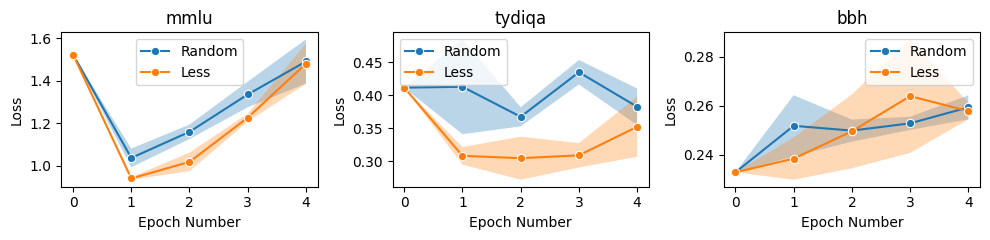

In [105]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create a plot for each task
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 2.5))
labels = ['Random', 'Less']
for i, data in enumerate([random_selection_losses, less_selection_losses]):
    df = dfs[i] 

    # Loop through each task and plot
    for ax, task in zip(axes, data.keys()):
        task_data = df[df['task'] == task]
        sns.lineplot(x='epoch', y='loss', data=task_data, ax=ax, marker='o', label=labels[i])
        lower_bound = task_data["loss"] - task_data["std"] 
        upper_bound = task_data["loss"] + task_data["std"]
        x_axis = task_data["epoch"]
        ax.fill_between(x_axis.values, lower_bound.values, upper_bound.values, alpha=.3)

        # Set title and labels
        ax.set_title(task)
        ax.set_xlabel('Epoch Number')
        ax.set_ylabel('Loss')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f"{model_name}_loss.pdf", bbox_inches='tight')


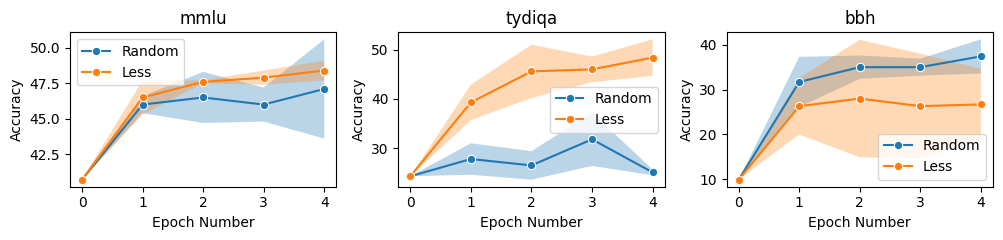

In [71]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create a plot for each task
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 2.5))
labels = ['Random', 'Less']

for i, data in enumerate([random_selection_losses, less_selection_losses]):
    # Convert to DataFrame
    df = dfs[i] 

    # Loop through each task and plot
    for ax, task in zip(axes, data.keys()):
        task_data = df[df['task'] == task]
        sns.lineplot(x='epoch', y='accuracy', data=task_data, ax=ax, marker='o', label=labels[i])
        lower_bound = task_data["accuracy"] - task_data["accuracy_std"]
        upper_bound = task_data["accuracy"] + task_data["accuracy_std"]
        x_axis = task_data["epoch"]
        ax.fill_between(x_axis.values, lower_bound.values, upper_bound.values, alpha=.3)
        # Set title and labels
        ax.set_title(task)
        ax.set_xlabel('Epoch Number')
        ax.set_ylabel('Accuracy')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [117]:
dfs[1]

,Unnamed: 0,task,checkpoint,loss,std,epoch,accuracy,accuracy_std,method
15,15,mmlu,0,1.522453,0.000000,0,61.100000,0.0,Less
16,16,mmlu,105,0.940245,0.005950,1,60.116959,1.8,Less
17,17,mmlu,211,1.018106,0.043578,2,62.690058,2.0,Less
18,18,mmlu,317,1.225953,0.018643,3,62.105263,1.4,Less
19,19,mmlu,420,1.479622,0.094117,4,62.690058,0.2,Less
20,20,tydiqa,0,0.411331,0.000000,0,24.200000,0.0,Less
21,21,tydiqa,105,0.308413,0.013250,1,40.035273,5.1,Less
22,22,tydiqa,211,0.304884,0.032496,2,37.399442,5.5,Less
23,23,tydiqa,317,0.309170,0.018366,3,47.160494,8.4,Less
24,24,tydiqa,420,0.352304,0.045243,4,51.060276,0.6,Less


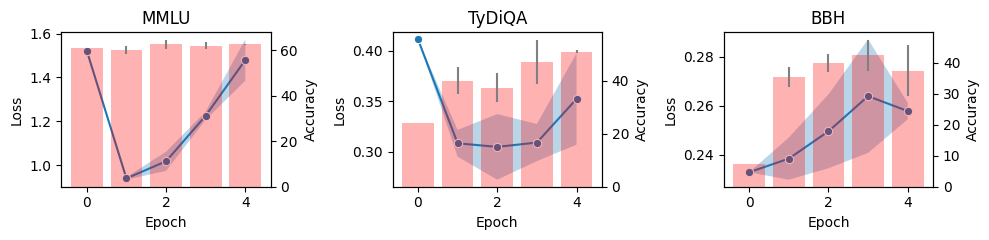

In [118]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create a plot for each task
fig, axes = plt.subplots(1, len(tasks), figsize=(10, 2.5))
labels = ['Random', 'Less']
losses = [random_selection_losses, less_selection_losses]
i = 1
task_names = ["MMLU", "TyDiQA", "BBH"]
for data in losses[1:]:
    df = dfs[i] 

    # Loop through each task and plot
    for j, (ax, task) in enumerate(zip(axes, data.keys())):
        task_data = df[df['task'] == task]
        sns.lineplot(x='epoch', y='loss', data=task_data, ax=ax, marker='o', )
        lower_bound = task_data["loss"] - task_data["std"]
        upper_bound = task_data["loss"] + task_data["std"]
        x_axis = task_data["epoch"]
        ax.fill_between(x_axis.values, lower_bound.values, upper_bound.values, alpha=.3)
        # ax.invert_yaxis()
        axx = ax.twinx()
        axx.bar(x_axis, task_data["accuracy"], alpha=0.3, color="red", yerr=task_data["accuracy_std"], ecolor="gray", )

        # Set title and labels
        ax.set_title(task_names[j])
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        axx.set_ylabel('Accuracy')
        # ax.legend(loc='lower right')
        # axx.legend(loc='lower right')



# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f"{model_name}_loss_acc.pdf")

In [83]:
model_name

'llama-2-13b-hf'

In [57]:
import pandas as pd

# Add a new field to indicate the type of dataframe
dfs[0]['method'] = 'Random'
dfs[1]['method'] = 'Less'

# Concatenate the dataframes in rows
merged_df = pd.concat([dfs[0], dfs[1]], ignore_index=True)

merged_df.to_csv(f"/scratch/gpfs/mengzhou/space10/final/loss/{model_name}/loss_acc.csv")


In [58]:
merged_df

,task,checkpoint,loss,std,epoch,accuracy,accuracy_std,method
0,mmlu,0,2.048611,0.000000,0,55.8,0.0,Random
1,mmlu,105,1.210491,0.007815,1,57.3,1.3,Random
2,mmlu,211,1.246322,0.015807,2,55.0,0.7,Random
3,mmlu,317,1.276657,0.015604,3,54.7,0.9,Random
4,mmlu,420,1.299274,0.013643,4,54.5,0.7,Random
5,tydiqa,0,0.418627,0.000000,0,53.1,0.0,Random
6,tydiqa,105,0.384097,0.002522,1,25.8,8.4,Random
7,tydiqa,211,0.387749,0.004267,2,26.9,3.5,Random
8,tydiqa,317,0.390958,0.001645,3,27.1,3.4,Random
9,tydiqa,420,0.388959,0.002763,4,36.0,3.0,Random
